# Tracing the Evolution of AI Coverage in the New York Times (2000–2024)

This notebook analyzes AI-related media coverage trends using:
- Temporal article frequency
- Sentiment evolution
- Calibration with non-AI topics

In [5]:
import pandas as pd

# Load the preprocessed AI articles
df_ai = pd.read_csv('../data/nyt-ai-sentiment.csv')

# Convert date and extract year
df_ai['pub_date'] = pd.to_datetime(df_ai['pub_date'], errors='coerce')
df_ai = df_ai.dropna(subset=['pub_date'])
df_ai['year'] = df_ai['pub_date'].dt.year

df_ai.head()

,pub_date,text,sentiment,sentiment_score,year
0,2000-02-03 05:00:00+00:00,"Hospitals nationwide, faced with growing conce...",neutral,0.677050,2000
1,2000-06-18 05:00:00+00:00,Gerald Jonas reviews books Evolution's Darling...,neutral,0.637411,2000
2,2000-07-25 05:00:00+00:00,Dr David B Fogel describes how computer progra...,neutral,0.595081,2000
3,2000-07-29 05:00:00+00:00,Correction of July 17 article on Microsoft's p...,neutral,0.569639,2000
4,2000-09-10 05:00:00+00:00,London Science Museum opens addition that expl...,neutral,0.819440,2000


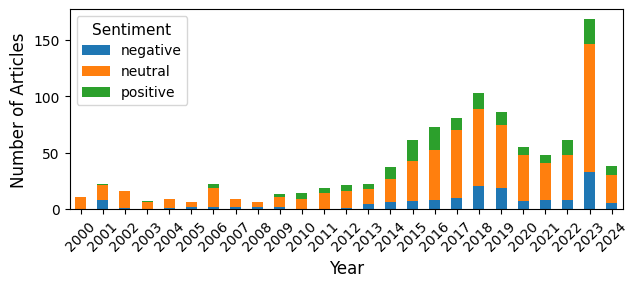


Raw sentiment counts per year:
sentiment  negative  neutral  positive
year                                  
2000              0       11         0
2001              8       13         1
2002              1       15         0
2003              0        6         1
2004              1        8         0
2005              2        4         0
2006              2       17         3
2007              2        7         0
2008              2        4         0
2009              2        9         2
2010              0        9         5
2011              0       14         5
2012              1       15         5
2013              4       14         4
2014              6       21        10
2015              7       36        18
2016              8       44        21
2017             10       60        11
2018             20       69        14
2019             19       56        11
2020              7       41         7
2021              8       33         7
2022              8       40    

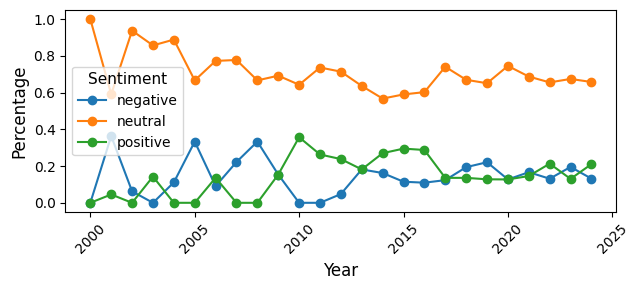


Sentiment percentages per year:
sentiment  negative  neutral  positive
year                                  
2000           0.00   100.00      0.00
2001          36.36    59.09      4.55
2002           6.25    93.75      0.00
2003           0.00    85.71     14.29
2004          11.11    88.89      0.00
2005          33.33    66.67      0.00
2006           9.09    77.27     13.64
2007          22.22    77.78      0.00
2008          33.33    66.67      0.00
2009          15.38    69.23     15.38
2010           0.00    64.29     35.71
2011           0.00    73.68     26.32
2012           4.76    71.43     23.81
2013          18.18    63.64     18.18
2014          16.22    56.76     27.03
2015          11.48    59.02     29.51
2016          10.96    60.27     28.77
2017          12.35    74.07     13.58
2018          19.42    66.99     13.59
2019          22.09    65.12     12.79
2020          12.73    74.55     12.73
2021          16.67    68.75     14.58
2022          13.11    65.57   

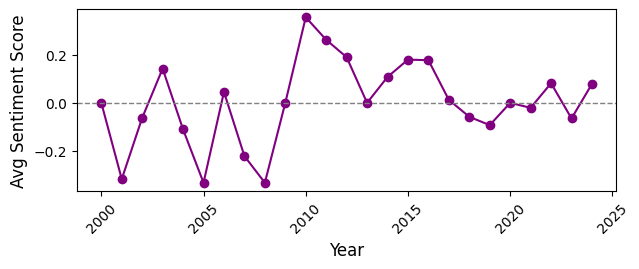


Average sentiment score per year:
year
2000    0.000
2001   -0.318
2002   -0.062
2003    0.143
2004   -0.111
2005   -0.333
2006    0.045
2007   -0.222
2008   -0.333
2009    0.000
2010    0.357
2011    0.263
2012    0.190
2013    0.000
2014    0.108
2015    0.180
2016    0.178
2017    0.012
2018   -0.058
2019   -0.093
2020    0.000
2021   -0.021
2022    0.082
2023   -0.065
2024    0.079
Name: sentiment_score_mapped, dtype: float64

Overall average sentiment score across all years:
0.012


In [23]:
import matplotlib.pyplot as plt

# Ensure required columns exist
assert 'year' in df_ai.columns and 'sentiment' in df_ai.columns, "Missing expected columns."

# Map sentiment labels to numeric scores for weighted trends
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df_ai['sentiment_score_mapped'] = df_ai['sentiment'].map(sentiment_map)

# 1. Count sentiment categories per year
sentiment_counts = df_ai.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# 2. Normalize to percentages per year
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# 3. Compute average sentiment score per year
avg_score_per_year = df_ai.groupby('year')['sentiment_score_mapped'].mean()

# -------- Plot 1: Raw counts of sentiment --------
plt.figure(figsize=(6.5, 3))
sentiment_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(title='Sentiment', fontsize=10, title_fontsize=11, loc='best')
plt.tight_layout()
plt.show()

print("\nRaw sentiment counts per year:")
print(sentiment_counts)

# -------- Plot 2: Sentiment percentages --------
plt.figure(figsize=(6.5, 3))
sentiment_percentages.plot(kind='line', marker='o', ax=plt.gca())
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend(title='Sentiment', fontsize=10, title_fontsize=11, loc='best')
plt.tight_layout()
plt.show()

print("\nSentiment percentages per year:")
print((sentiment_percentages * 100).round(2))

# -------- Plot 3: Average sentiment score --------
plt.figure(figsize=(6.5, 2.8))
avg_score_per_year.plot(kind='line', marker='o', color='purple')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg Sentiment Score', fontsize=12)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

print("\nAverage sentiment score per year:")
print(avg_score_per_year.round(3))

print("\nOverall average sentiment score across all years:")
overall_avg_sentiment = df_ai['sentiment_score_mapped'].mean()
print(overall_avg_sentiment.round(3))


## Normalized Frequency of AI-related Articles Over Time

In this section, we analyze how the relative importance of AI in New York Times coverage has evolved between 2000 and 2024.

To avoid misleading conclusions based on raw article counts (which can fluctuate due to changing publication volume), we compute the **percentage of AI-related articles per year**, normalized by the total number of NYT articles published in that year.

Key steps:
- Re-load the full `nyt-metadata.csv` file (not just filtered AI articles).
- Re-apply the AI detection logic used in preprocessing.
- Calculate and plot both:
  - Absolute number of AI vs. total articles.
  - **Percentage of AI coverage** (AI articles / total articles × 100).

This normalization helps address the calibration feedback we received, ensuring that increases in AI mentions are not simply due to overall growth in media output.


In [26]:
import re

# Load all NYT metadata
df_all = pd.read_csv('../data/nyt-metadata.csv')

# Parse publication date
df_all['pub_date'] = pd.to_datetime(df_all['pub_date'], errors='coerce')
df_all = df_all.dropna(subset=['pub_date'])
df_all['year'] = df_all['pub_date'].dt.year
df_all = df_all[(df_all['pub_date'] >= '2000-01-01') & (df_all['pub_date'] <= '2024-12-31')]

# Combine relevant text fields (same logic as in your script)
text_columns = ['abstract', 'lead_paragraph', 'snippet', 'headline']
df_all['text'] = ''
for col in text_columns:
    if col in df_all.columns:
        df_all['text'] += ' ' + df_all[col].fillna('')
df_all['text'] = df_all['text'].str.strip()

# Define AI detection function again (simplified copy from your script)
def is_ai_related_article(text):
    if text is None or pd.isna(text) or text.strip() == '':
        return False
    text = text.lower()
    for term in ['artificial intelligence', 'machine learning', 'deep learning', 'neural network', 'neural networks']:
        if term in text:
            return True
    ai_matches = re.finditer(r'\b(ai)\b', text)
    context_words = ['technology', 'computer', 'algorithm', 'model', 'system', 'research', 'robot', 'automated', 'smart', 'intelligent']
    for match in ai_matches:
        start = max(0, match.start() - 50)
        end = min(len(text), match.end() + 50)
        context = text[start:end]
        for context_word in context_words:
            if context_word in context:
                return True
        if re.search(r'ai (system|model|algorithm|technology|research|program|tool)', context):
            return True
        if re.search(r'(use of|using|powered by|based on) ai', context):
            return True
    return False

# Detect AI-related articles (can take a few minutes)
print("Detecting AI-related articles...")
df_all['is_ai'] = df_all['text'].apply(is_ai_related_article)

# Aggregate yearly counts
yearly_counts = df_all.groupby('year').agg(
    total_articles=('text', 'count'),
    ai_articles=('is_ai', 'sum')
)

# Calculate normalized AI percentage
yearly_counts['ai_percent'] = yearly_counts['ai_articles'] / yearly_counts['total_articles'] * 100


C:\Users\bogda\AppData\Local\Temp\ipykernel_28968\1317458519.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('../data/nyt-metadata.csv')


Detecting AI-related articles...


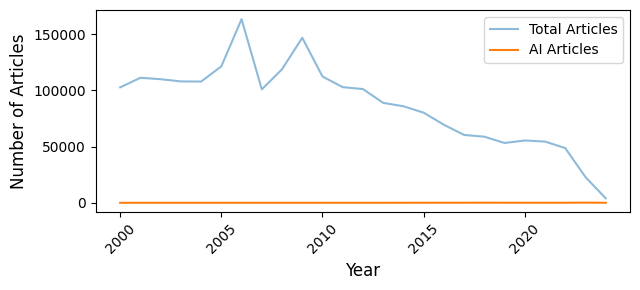


Raw count of total vs. AI articles per year:
      total_articles  ai_articles
year                             
2000          102800           11
2001          111312           22
2002          110050           16
2003          108072            7
2004          107947            9
2005          121485            6
2006          163480           22
2007          100973            9
2008          118895            6
2009          146939           13
2010          112448           14
2011          102969           19
2012          101255           21
2013           88984           22
2014           85951           37
2015           80252           61
2016           69489           73
2017           60414           81
2018           58849          103
2019           53258           86
2020           55493           55
2021           54529           48
2022           48706           61
2023           22874          169
2024            3990           38


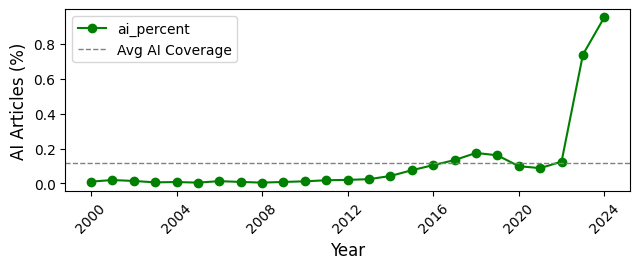


Percentage of AI articles per year (%):
year
2000    0.01
2001    0.02
2002    0.01
2003    0.01
2004    0.01
2005    0.00
2006    0.01
2007    0.01
2008    0.01
2009    0.01
2010    0.01
2011    0.02
2012    0.02
2013    0.02
2014    0.04
2015    0.08
2016    0.11
2017    0.13
2018    0.18
2019    0.16
2020    0.10
2021    0.09
2022    0.13
2023    0.74
2024    0.95
Name: ai_percent, dtype: float64


In [28]:
# -------- Plot 1: Raw AI vs total articles --------
plt.figure(figsize=(6.5, 3))
yearly_counts['total_articles'].plot(label='Total Articles', alpha=0.5)
yearly_counts['ai_articles'].plot(label='AI Articles')

years = yearly_counts.index.tolist()
plt.xticks(
    ticks=[y for y in years if y % 5 == 0],
    labels=[y for y in years if y % 5 == 0],
    fontsize=10, rotation=45
)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\nRaw count of total vs. AI articles per year:")
print(yearly_counts[['total_articles', 'ai_articles']])

# -------- Plot 2: Percentage of AI articles --------
plt.figure(figsize=(6.5, 2.8))
yearly_counts['ai_percent'].plot(marker='o', color='green')

plt.xticks(
    ticks=[y for y in years if y % 4 == 0],
    labels=[y for y in years if y % 4 == 0],
    fontsize=10, rotation=45
)

plt.axhline(y=yearly_counts['ai_percent'].mean(), color='gray', linestyle='--', linewidth=1, label='Avg AI Coverage')

plt.xlabel('Year', fontsize=12)
plt.ylabel('AI Articles (%)', fontsize=12)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print("\nPercentage of AI articles per year (%):")
print(yearly_counts['ai_percent'].round(2))

## AI vs Other Topics in NYT

Other topics (Politics, Health, Business, Sports, and non-AI Tech) are detected using keyword-based matching on the original dataset. For each topic, we calculate the percentage of total NYT articles in a given year that relate to it.

This gives a calibrated view of how AI coverage compares to other dominant themes in the media over time.


In [29]:
# Load sentiment-labeled AI articles with year info
df_ai = pd.read_csv('../data/nyt-ai-sentiment.csv')
df_ai['pub_date'] = pd.to_datetime(df_ai['pub_date'], errors='coerce')
df_ai = df_ai.dropna(subset=['pub_date'])
df_ai['year'] = df_ai['pub_date'].dt.year

# Reload full NYT dataset
df_all = pd.read_csv('../data/nyt-metadata.csv')
df_all['pub_date'] = pd.to_datetime(df_all['pub_date'], errors='coerce')
df_all = df_all.dropna(subset=['pub_date'])
df_all = df_all[(df_all['pub_date'] >= '2000-01-01') & (df_all['pub_date'] <= '2024-12-31')]
df_all['year'] = df_all['pub_date'].dt.year
df_all['text'] = ''
for col in ['abstract', 'lead_paragraph', 'snippet', 'headline']:
    if col in df_all.columns:
        df_all['text'] += ' ' + df_all[col].fillna('')
df_all['text'] = df_all['text'].str.strip()

# Add AI flag based on previously filtered articles
ai_counts = df_ai.groupby('year').size().to_frame(name='AI')

# Define non-AI topic keywords
TOPIC_KEYWORDS = {
    "Politics": ['election', 'government', 'senate', 'congress', 'policy', 'president', 'campaign'],
    "Health": ['health', 'medicine', 'covid', 'vaccine', 'disease', 'hospital', 'mental health'],
    "Business": ['stock', 'market', 'economy', 'business', 'finance', 'company'],
    "Sports": ['game', 'team', 'player', 'season', 'nba', 'football', 'world cup', 'olympics'],
    "TechNoAI": ['technology', 'computer', 'software', 'internet', 'gadget', 'innovation', 'robotic']
}

# Detect non-AI topics
for topic, keywords in TOPIC_KEYWORDS.items():
    pattern = r'\b(?:' + '|'.join(re.escape(k) for k in keywords) + r')\b'
    df_all[f'is_{topic}'] = df_all['text'].str.contains(pattern, case=False, na=False)

# Count total articles per year
total_articles_per_year = df_all.groupby('year')['text'].count().to_frame(name='Total')

# Count other topics
topic_counts = df_all.groupby('year')[[f'is_{topic}' for topic in TOPIC_KEYWORDS]].sum()
topic_counts.columns = [topic for topic in TOPIC_KEYWORDS]

# Combine all topic counts, including AI
topic_counts = topic_counts.join(ai_counts, how='outer').fillna(0).astype(int)
topic_counts = topic_counts.join(total_articles_per_year, how='inner')

# Normalize to %
topic_percent = topic_counts.div(topic_counts['Total'], axis=0) * 100
topic_percent = topic_percent.drop(columns='Total')

C:\Users\bogda\AppData\Local\Temp\ipykernel_28968\4004535227.py:8: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('../data/nyt-metadata.csv')


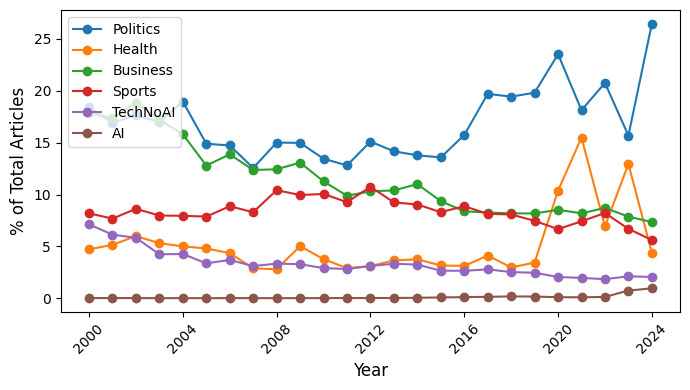


Normalized topic coverage by year (%):
      Politics  Health  Business  Sports  TechNoAI    AI
year                                                    
2000     18.39    4.72     17.87    8.19      7.12  0.01
2001     16.91    5.14     17.37    7.67      6.13  0.02
2002     17.64    6.00     18.85    8.62      5.82  0.01
2003     17.00    5.30     17.22    7.98      4.23  0.01
2004     18.96    5.00     15.80    7.95      4.26  0.01
2005     14.90    4.80     12.80    7.87      3.36  0.00
2006     14.73    4.35     13.87    8.87      3.69  0.01
2007     12.56    2.88     12.36    8.29      3.10  0.01
2008     15.01    2.80     12.43   10.42      3.33  0.01
2009     14.98    5.03     13.07    9.95      3.28  0.01
2010     13.45    3.76     11.27   10.06      2.91  0.01
2011     12.80    2.90      9.88    9.26      2.82  0.02
2012     15.11    3.09     10.31   10.75      3.11  0.02
2013     14.16    3.65     10.40    9.24      3.32  0.02
2014     13.78    3.75     11.00    9.04      3.

In [36]:
# Plot
plt.figure(figsize=(7, 4))
topic_percent.plot(marker='o', ax=plt.gca())

# Set ticks every 5 years
years = topic_percent.index.tolist()
plt.xticks(
    ticks=[y for y in years if y % 4 == 0],
    labels=[y for y in years if y % 4 == 0],
    fontsize=10, rotation=45
)

plt.ylabel('% of Total Articles', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.yticks(fontsize=10)
plt.legend(fontsize=10, title_fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

# Print values to help write Results
print("\nNormalized topic coverage by year (%):")
print(topic_percent.round(2))